In [1]:
# Citation: a slight modification of "rizkidesu" code

In [2]:
import tensorflow as tf
print(f'Tensorflow version used: {tf.__version__}')

Tensorflow version used: 2.12.0


In [3]:
import numpy as np
np.__version__

'1.23.5'

In [4]:
import numpy as np 
import pandas as pd
import os

In [5]:
image_paths = {
    "train_cataract" : [],
    "train_normal" : [],
    "test_cataract" : [],
    "test_normal" : []
}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        if "train/cataract" in path:
            image_paths["train_cataract"].append(path)
        elif "train/normal" in path:
            image_paths["train_normal"].append(path)
        elif "test/cataract" in path:
            image_paths["test_cataract"].append(path)
        elif "test/normal" in path:
            image_paths["test_normal"].append(path)

In [6]:
print('NORMAL IMAGES')
print('-------------')
print(f'Train Size: {len(image_paths["train_normal"])}')
print(f'Test Size: {len(image_paths["test_normal"])}')

print()

print('CATARACT IMAGES')
print('---------------')
print(f'Train Size: {len(image_paths["train_cataract"])}')
print(f'Test Size: {len(image_paths["test_cataract"])}')

print()

total_images = len(image_paths["train_cataract"]) + len(image_paths["test_cataract"])
train_ratio = int(round(len(image_paths["train_cataract"]) / total_images * 100, 0))
test_ratio = int(round(len(image_paths["test_cataract"]) / total_images * 100, 0))

print(f'Train-Test Split Ratio - ({train_ratio}:{test_ratio})')

NORMAL IMAGES
-------------
Train Size: 246
Test Size: 60

CATARACT IMAGES
---------------
Train Size: 245
Test Size: 61

Train-Test Split Ratio - (80:20)


In [7]:
from PIL import Image
from matplotlib import pyplot as plt

size of image : (235, 311, 3)


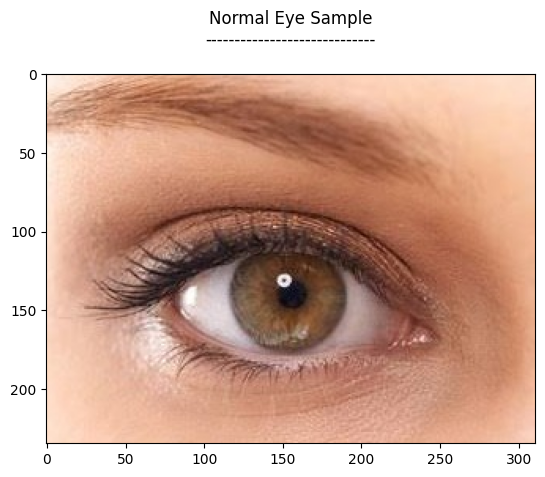

In [8]:
sample_img = np.array(Image.open(image_paths["test_normal"][1]))
print(f"size of image : {np.shape(sample_img)}")
plt.title('Normal Eye Sample\n-----------------------------\n')
plt.imshow(sample_img)

size of image : (1080, 1920, 3)


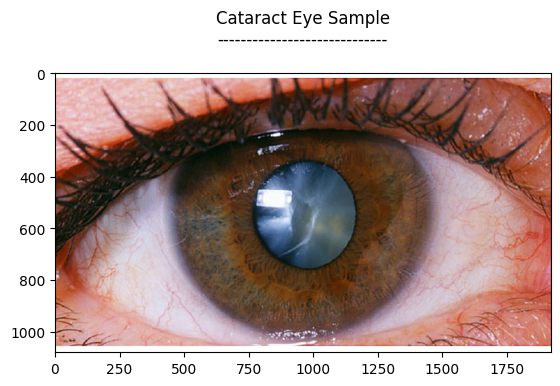

In [9]:
sample_img = np.array(Image.open(image_paths["test_cataract"][0]))
print(f"size of image : {np.shape(sample_img)}")
plt.title('Cataract Eye Sample\n-----------------------------\n')
plt.imshow(sample_img)

In [10]:
training_dir = "/kaggle/input/cataract-image-dataset/processed_images/train/"
image_size = (55, 94, 3)
target_size = (55, 94)

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size = target_size,
    class_mode = 'binary'
)

Found 491 images belonging to 2 classes.


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers.experimental import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu',input_shape=image_size),
    MaxPooling2D(2, 2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 53, 92, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 44, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 22, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8448)              0         
                                                                 
 dense (Dense)               (None, 128)               1

In [16]:
optimizer = Adam(learning_rate=0.001)

model.compile(
    loss = 'binary_crossentropy',
    optimizer=RMSprop(lr=0.001),
#     optimizer=optimizer,
    metrics=['accuracy'], 
)

In [17]:
history = model.fit(
    train_generator,
    epochs=20
)

Epoch 1/20
16/16 [==============================] - 24s 1s/step - loss: 0.6845 - accuracy: 0.5458
Epoch 2/20
16/16 [==============================] - 16s 1s/step - loss: 0.5392 - accuracy: 0.7882
Epoch 3/20
16/16 [==============================] - 17s 1s/step - loss: 0.4447 - accuracy: 0.8106
Epoch 4/20
16/16 [==============================] - 18s 1s/step - loss: 0.3854 - accuracy: 0.8289
Epoch 5/20
16/16 [==============================] - 18s 1s/step - loss: 0.3444 - accuracy: 0.8676
Epoch 6/20
16/16 [==============================] - 18s 1s/step - loss: 0.3078 - accuracy: 0.8717
Epoch 7/20
16/16 [==============================] - 16s 1s/step - loss: 0.2760 - accuracy: 0.8859
Epoch 8/20
16/16 [==============================] - 17s 1s/step - loss: 0.2532 - accuracy: 0.9124
Epoch 9/20
16/16 [==============================] - 17s 1s/step - loss: 0.2232 - accuracy: 0.9063
Epoch 10/20
16/16 [==============================] - 16s 1s/step - loss: 0.1923 - accuracy: 0.9369
Epoch 11/20
16/16 [

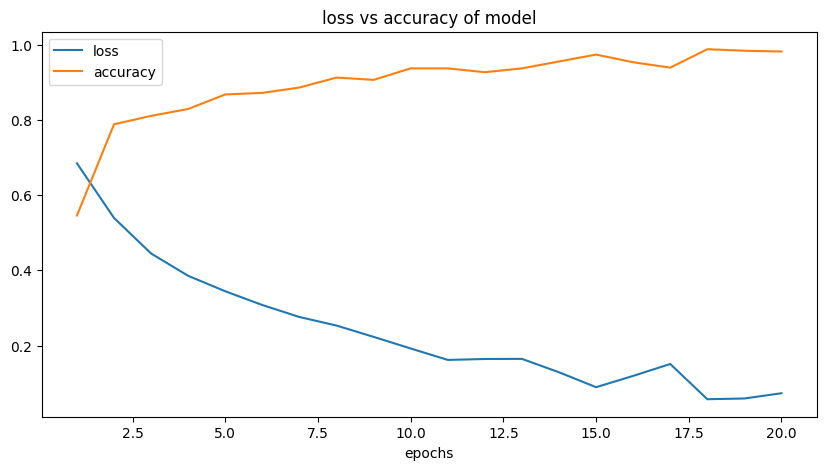

In [18]:
epochs = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(10, 5))
plt.title("loss vs accuracy of model")
plt.plot(epochs, history.history['loss'], label='loss')
plt.plot(epochs, history.history['accuracy'], label='accuracy')
plt.grid()
plt.xlabel("epochs")
plt.grid()
plt.legend()

In [19]:
import tensorflow as tf

In [20]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [21]:
label = train_generator.class_indices
print(f'Class Labels: {label}')

Class Labels: {'cataract': 0, 'normal': 1}


In [22]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict(model, img_path, actual_class='', show_image=True):
    image = Image.open(img_path)
#     plt.imshow(np.array(img))
    img = np.array(image.resize((94, 55)))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)
    predicted_class = 'normal' if pred[0] > 0.5 else 'cataract'
#     print("actual class : cataract")
#     print(f"predicted class : {predicted_class}")
    
    
    results = ''
    if actual_class:
        results = f'{{Actual: {actual_class}, Predicted: {predicted_class}}}'
    else:
        results = f'{{Predicted: {predicted_class}}}'
    
    if show_image:
        plt.title(results)
        plt.imshow(np.array(image))
        plt.axis('off')
    else:
        print(results)

In [23]:
path1 = image_paths["test_cataract"][0]
path2 = image_paths["test_normal"][1]

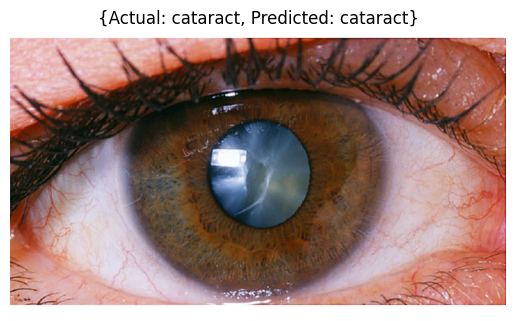

In [24]:
# Test cataract
predict(model, path1, actual_class='cataract', show_image=True)

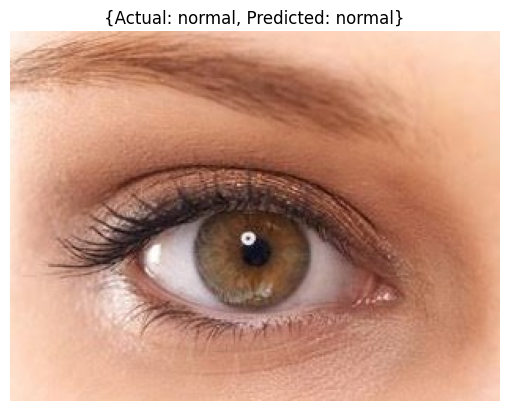

In [25]:
# Test normal
predict(model, path2, actual_class='normal', show_image=True)

In [26]:
def _predict(model, path):
    img = np.array(Image.open(path).resize((94, 55)))
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img, verbose=0)
    if pred[0] > 0.5:
        return 'normal'
    else:
        return 'cataract'

In [27]:
def evaluate(model, normal_path, cataract_path):
    normal_pred = []
    cataract_pred = []
    for normal, cataract in zip(normal_path, cataract_path):
        res_cataract = _predict(model, cataract)
        cataract_pred.append(res_cataract)
        
        res_normal = _predict(model, normal)
        normal_pred.append(res_normal)
    
    return normal_pred, cataract_pred

In [28]:
both_size = min(len(image_paths["test_normal"]), len(image_paths["test_cataract"]))
                                                                 
cataract_test_path = image_paths["test_cataract"][:both_size]
normal_test_path = image_paths["test_normal"][:both_size]
                                                                 
normal_pred, cataract_pred = evaluate(model, image_paths["test_normal"], image_paths["test_cataract"])

In [29]:
pred_df = pd.DataFrame()
pred_df["relative_path"] = normal_test_path + cataract_test_path
pred_df["actual_class"] = ["normal"]*len(normal_test_path) + ["cataract"]*len(cataract_test_path)
pred_df["predicted_class"] = normal_pred + cataract_pred

In [30]:
pred_df.head(20)

,relative_path,actual_class,predicted_class
0,/kaggle/input/cataract-image-dataset/processed...,normal,normal
1,/kaggle/input/cataract-image-dataset/processed...,normal,normal
2,/kaggle/input/cataract-image-dataset/processed...,normal,cataract
3,/kaggle/input/cataract-image-dataset/processed...,normal,normal
4,/kaggle/input/cataract-image-dataset/processed...,normal,normal
5,/kaggle/input/cataract-image-dataset/processed...,normal,normal
6,/kaggle/input/cataract-image-dataset/processed...,normal,cataract
7,/kaggle/input/cataract-image-dataset/processed...,normal,normal
8,/kaggle/input/cataract-image-dataset/processed...,normal,normal
9,/kaggle/input/cataract-image-dataset/processed...,normal,normal


In [31]:
pred_df.tail(20)

,relative_path,actual_class,predicted_class
100,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
101,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
102,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
103,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
104,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
105,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
106,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
107,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
108,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract
109,/kaggle/input/cataract-image-dataset/processed...,cataract,cataract


In [32]:
tp = tn = fp = fn = 0
for actual, predicted in zip(list(pred_df['actual_class']), list(pred_df['predicted_class'])):
    if actual == 'normal' and predicted == 'normal':
        tp = tp + 1
    elif actual == 'cataract' and predicted == 'cataract':
        tn = tn + 1
    elif actual == 'normal' and predicted == 'cataract':
        fp = fp + 1
    elif actual == 'cataract' and predicted == 'normal':
        fn = fn + 1

In [33]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

In [34]:
evaluation_summary = pd.DataFrame()
evaluation_summary["accuracy"] = [accuracy]
evaluation_summary["precision"] = [precision]
evaluation_summary["recall"] = [recall]
evaluation_summary["f1"] = [f1]

In [35]:
results = evaluation_summary.T.round(2)
results.rename(columns={0:'scores'}, inplace=True)
results

,scores
accuracy,0.88
precision,0.80
recall,0.94
f1,0.86


<Axes: title={'center': 'Model Performance for Cataract Classifer Model\n'}>

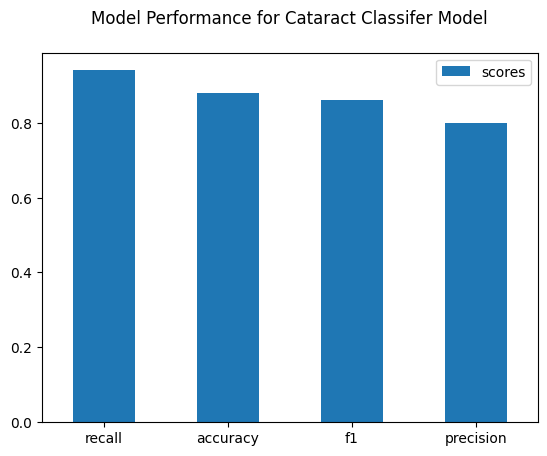

In [36]:
results.sort_values(by='scores', ascending=False).plot(kind='bar', title='Model Performance for Cataract Classifer Model\n', rot=0)

In [37]:
model.save("/kaggle/working/cataract_classifier_model.h5")
model.save("/kaggle/working/cataract_classifier_model.keras")

---
# Loading trained models and Inferencing

---

In [38]:
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

def predict(model, img_path, actual_class='', show_image=True):
    image = load_img(img_path, target_size=(55,94))
    image = img_to_array(image)
    img = np.expand_dims(image, axis=0)
    pred = model.predict(img, verbose=0)
    predicted_class = 'normal' if pred[0] > 0.5 else 'cataract'
    
    results = ''
    if actual_class:
        results = f'( Actual: {actual_class}, Predicted: {predicted_class} )'
    else:
        results = f'( Predicted: {predicted_class} )'
    
    if show_image:
        img = plt.imread(img_path)
        plt.title(results)
        plt.imshow(img)
        plt.axis('off')
    else:
        print(results)

In [39]:
model_dir = '/kaggle/input/cataract-classifiers/keras/default/1'
trained_model = load_model(os.path.join(model_dir, 'cataract_classifier_model.h5'))

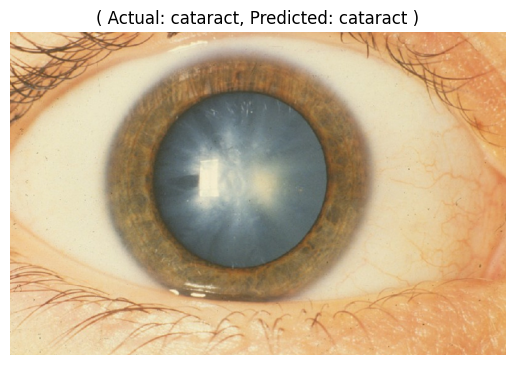

In [40]:
testimage_path = '/kaggle/input/cataract-image-dataset/processed_images/test/cataract/image_248.png'
predict(trained_model, testimage_path, actual_class='cataract', show_image=True)

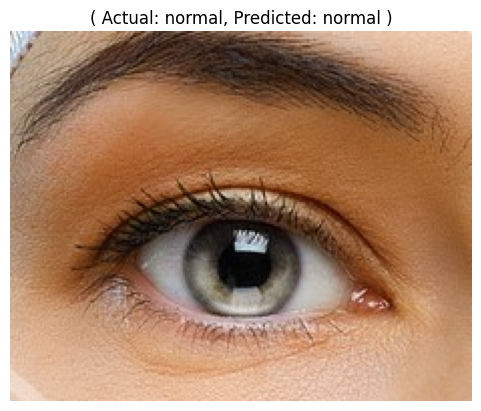

In [41]:
testimage_path = '/kaggle/input/cataract-image-dataset/processed_images/test/normal/image_250.png'
predict(trained_model, testimage_path, actual_class='normal', show_image=True)